In [1]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from agent import Agent, advanced_random_policy, random_policy, advanced_policy_nD, sarsa
from game import Game
import neuralAgent as na
import matplotlib.pyplot as plt
import numpy as np

### In a first time, we train an agent for 2D tic-tac-toe using our modified SARSA algorithm

In [48]:
%%time
# Around 3 mins to train our agent with 20 000 episodes
game = Game(None, None, n_dim=2, size=3)
agent_sarsa = Agent(size=3)

n_eps = 20000
# Trains agent with the advanced policy
sarsa(game, agent_sarsa, advanced_random_policy, alpha=0.45, alpha_factor=0.9995**(10000/n_eps), gamma=0.7, epsilon=1.0, \
      epsilon_factor=0.9997**(10000/n_eps), r_win=11.0, r_lose=0.0, r_even=1.0, r_even2=1.25, num_episodes=20000)

100%|██████████| 20000/20000 [03:06<00:00, 107.52it/s]

Wall time: 3min 6s


We make our agent play 1000 games against the <b>random</b> policy (agent plays first in half of the games)

In [49]:
random_opponent = Agent(size=3, policy=random_policy)
game = Game(agent_sarsa, random_opponent, n_dim=2, size=3)

agent_1_win, oppo_2_win, agent_1_even, agent_2_win, oppo_1_win, agent_2_even = game.simulate_games(1000)
tot_agent_win = agent_1_win + agent_2_win
tot_agent_lose = oppo_1_win + oppo_2_win
tot_even = agent_1_even + agent_2_even
print("On 1000 games, agent won", tot_agent_win, "times, lost", tot_agent_lose, "times and made", tot_even, "even games.")

On 1000 games, agent won 643 times, lost 121 times and made 236 even games.


Now we make our agent play 1000 games against the <b>advanced</b> policy (agent plays first in half of the games)

In [50]:
advanced_opponent = Agent(size=3, policy=advanced_random_policy)
game = Game(agent_sarsa, advanced_opponent, n_dim=2, size=3)

agent_1_win, oppo_2_win, agent_1_even, agent_2_win, oppo_1_win, agent_2_even = game.simulate_games(1000)
tot_agent_win = agent_1_win + agent_2_win
tot_agent_lose = oppo_1_win + oppo_2_win
tot_even = agent_1_even + agent_2_even
print("On 1000 games, agent won", tot_agent_win, "times, lost", tot_agent_lose, "times and made", tot_even, "even games.")

On 1000 games, agent won 473 times, lost 13 times and made 514 even games.


#### We give the possibility to play against our agent

In [51]:
game = Game(agent_sarsa, "Human player", n_dim=2, size=3) # agent plays first
#game = Game("Human player", agent, n_dim=2, size=3) # to play first
game.play_a_game()

. . . 
. . . 
. . . 

Agent plays : (2, 2) 

. . . 
. . . 
. . X 

Coordinates of next move : 00

O . . 
. . . 
. . X 

Agent plays : (0, 2) 

O . X 
. . . 
. . X 

Coordinates of next move : 12

O . X 
. . O 
. . X 

Agent plays : (2, 0) 

O . X 
. . O 
X . X 

Coordinates of next move : 11

O . X 
. O O 
X . X 

Agent plays : (2, 1) 

O . X 
. O O 
X X X 

Game over. Score : (1, 0)
<agent.Agent object at 0x0000026F3D261E80> wins !


(1, 0)

We can evaluate the performances of our agent depending on the number of training episodes

In [6]:
win1, lose1, draw1, win2, lose2, draw2, n_eps = [], [], [], [], [], [], []
for n in [1, 10, 100, 200, 400, 700, 1000, 2000, 3000, 4000, 5000, 7000, 10000, 15000, 20000]:
    ar = 0.9995**(10000/n)
    er = 0.9997**(10000/n)
    agent = Agent(size=3)
    advanced_opponent = Agent(size=3, policy=advanced_random_policy)
    game = Game(agent, advanced_opponent, n_dim=2, size=3)
    sarsa(game, agent, advanced_random_policy, alpha=0.45, alpha_factor=ar, gamma=0.7, epsilon=1.0, epsilon_factor=er, \
          r_win=11.0, r_lose=0.0, r_even=1.0, r_even2=1.25, num_episodes=n)
    win_p1_a, win_p2_a, tot_even_a, win_p1_b, win_p2_b, tot_even_b = game.simulate_games(10000)
    win1.append(win_p1_a)
    win2.append(win_p1_b)
    lose1.append(win_p2_a)
    lose2.append(win_p2_b)
    draw1.append(tot_even_a)
    draw2.append(tot_even_b)
    n_eps.append(n)

100%|██████████| 20000/20000 [02:53<00:00, 115.39it/s]


Results when the agent plays <b>in first</b>

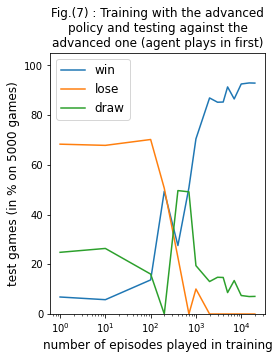

In [7]:
n_eps = np.array(n_eps)
fig = plt.figure(figsize=(0.6*6.4, 1*4.8))
plt.plot(n_eps, np.array(win1)/50, label='win')
plt.plot(n_eps, np.array(lose1)/50, label='lose')
plt.plot(n_eps, np.array(draw1)/50, label='draw')
plt.xscale('log')
plt.xlabel('number of episodes played in training', fontsize='large')
plt.ylabel('test games (in % on 5000 games)', fontsize='large')
plt.ylim(0, 105)
plt.title('Fig.(7) : Training with the advanced\npolicy and testing against the\nadvanced one (agent plays in first)')
plt.legend(loc='best', fontsize='large')
plt.savefig("plot1.pdf", bbox_inches='tight')

Results when the agent plays <b>in second</b>

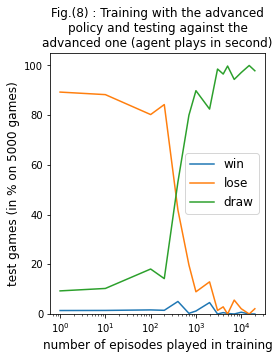

In [8]:
n_eps = np.array(n_eps)
fig = plt.figure(figsize=(0.6*6.4, 1*4.8))
plt.plot(n_eps, np.array(win2)/50, label='win')
plt.plot(n_eps, np.array(lose2)/50, label='lose')
plt.plot(n_eps, np.array(draw2)/50, label='draw')
plt.xscale('log')
plt.xlabel('number of episodes played in training', fontsize='large')
plt.ylabel('test games (in % on 5000 games)', fontsize='large')
plt.ylim(0, 105)
plt.title('Fig.(8) : Training with the advanced\npolicy and testing against the\nadvanced one (agent plays in second)')
plt.legend(loc='best', fontsize='large')
plt.savefig("plot2.pdf", bbox_inches='tight')

### Now, we show our Policy Gradient model for 2D, 3D and 4D
We start by the 2D case.<br>We train our model with 20 000 iteration and batch size of 1000.<br><br>
You can skip this part and directly load the weights of our model in the next cell.

In [9]:
game = Game(None, None, n_dim=2, size=3)
agent_2D = na.Model()
agent_2D, values, _, _, _ = na.train_network(agent_2D, game, 20000, 1000)
agent_2D.save("weights_2D")
print(values)

100%|██████████| 20000/20000 [01:56<00:00, 171.47it/s]

[array(0.22507074, dtype=float32), array(0.22507074, dtype=float32), array(0.24215935, dtype=float32), array(0.24215935, dtype=float32), array(0.23204531, dtype=float32), array(0.23204531, dtype=float32), array(0.2238855, dtype=float32), array(0.2238855, dtype=float32), array(0.23684725, dtype=float32), array(0.23684725, dtype=float32), array(0.24908169, dtype=float32), array(0.24908169, dtype=float32), array(0.22416365, dtype=float32), array(0.22416365, dtype=float32), array(0.24700518, dtype=float32), array(0.24700518, dtype=float32), array(0.22066577, dtype=float32), array(0.22066577, dtype=float32), array(0.23307395, dtype=float32), array(0.23307395, dtype=float32), array(0.2274512, dtype=float32), array(0.2274512, dtype=float32), array(0.2123587, dtype=float32), array(0.2123587, dtype=float32), array(0.23640522, dtype=float32), array(0.23640522, dtype=float32), array(0.21989647, dtype=float32), array(0.21989647, dtype=float32), array(0.21555898, dtype=float32), array(0.21555898, d

We make our agent play 1000 games against the random policy (agent plays first in half of the games)

In [10]:
loaded_agent_2D = na.Model()
# Loading a saved agent
loaded_agent_2D.load("weights_2D")
game = Game(None, None, n_dim=2, size=3)
wins, draw, loses = na.test_against_policy(loaded_agent_2D, game, random_policy, 1000)
print("Agent against the random policy in 2D : Win {}, Draw {}, Loses {}".format(wins, draw, loses))

100%|██████████| 1000/1000 [00:05<00:00, 172.46it/s]

Agent against the random policy in 2D : Win 648, Draw 61, Loses 291


#### Now the 3D case
We train our agent with the advanced policy (you can also skip this cell)

In [11]:
%%time
game = Game(None, None, n_dim=3, size=3)
agent_3D = na.Model(3, 3)
agent_3D, values, _, _, _ = na.train_network(agent_3D, game, 200000, 1000, policy=advanced_policy_nD)
agent_3D.save("weights_3D")
#print(values)

100%|██████████| 200000/200000 [4:43:01<00:00, 11.78it/s]  

Wall time: 4h 43min 2s


We show its performances against the random policy (agent plays first in half of the games)

In [12]:
loaded_agent_3D = na.Model(3, 3)
loaded_agent_3D.load("weights_3D")
game = Game(None, None, n_dim=3, size=3)
wins, draw, loses = na.test_against_random(agent_3D, game, 1000)
print("Agent against random policy in 3D : Win {}, Draw {}, Loses {}".format(wins, draw, loses))

100%|██████████| 1000/1000 [01:12<00:00, 13.82it/s]

Agent against random policy in 3D : Win 893, Draw 32, Loses 75


and against the advanced one

In [13]:
wins, draw, loses = na.test_against_policy(agent_3D, game, advanced_policy_nD, 1000)
print("Agent against advanced policy in 3D : Win {}, Draw {}, Loses {}".format(wins, draw, loses))

100%|██████████| 1000/1000 [01:24<00:00, 11.82it/s]

Agent against advanced policy in 3D : Win 217, Draw 144, Loses 639


#### You can try a game in 3D vs our agent

In [53]:
game = Game(agent, "Human player", n_dim=3, size=3) # agent plays first
#game = Game("Human player", agent, n_dim=3, size=3) # to play first
game.play_a_game()

['.' '.' '.'] ['.' '.' '.'] ['.' '.' '.'] 
['.' '.' '.'] ['.' '.' '.'] ['.' '.' '.'] 
['.' '.' '.'] ['.' '.' '.'] ['.' '.' '.'] 

Agent plays : (2, 0, 1) 

['.' '.' '.'] ['.' '.' '.'] ['.' '.' '.'] 
['.' '.' '.'] ['.' '.' '.'] ['.' '.' '.'] 
['.' 'X' '.'] ['.' '.' '.'] ['.' '.' '.'] 

Coordinates of next move : 000

['O' '.' '.'] ['.' '.' '.'] ['.' '.' '.'] 
['.' '.' '.'] ['.' '.' '.'] ['.' '.' '.'] 
['.' 'X' '.'] ['.' '.' '.'] ['.' '.' '.'] 

Agent plays : (2, 1, 2) 

['O' '.' '.'] ['.' '.' '.'] ['.' '.' '.'] 
['.' '.' '.'] ['.' '.' '.'] ['.' '.' '.'] 
['.' 'X' '.'] ['.' '.' 'X'] ['.' '.' '.'] 

Coordinates of next move : 001

['O' 'O' '.'] ['.' '.' '.'] ['.' '.' '.'] 
['.' '.' '.'] ['.' '.' '.'] ['.' '.' '.'] 
['.' 'X' '.'] ['.' '.' 'X'] ['.' '.' '.'] 

Agent plays : (2, 0, 2) 

['O' 'O' '.'] ['.' '.' '.'] ['.' '.' '.'] 
['.' '.' '.'] ['.' '.' '.'] ['.' '.' '.'] 
['.' 'X' 'X'] ['.' '.' 'X'] ['.' '.' '.'] 

Coordinates of next move : 002

['O' 'O' 'O'] ['.' '.' '.'] ['.' '.' '.'] 
['.

(8, 8)

### Finally we show some results in 4D

In [15]:
%%time
game = Game(None, None, n_dim=4, size=3)
agent_4D = na.Model(size=3, n_dim=4)
agent_4D, values, _, _, _ = na.train_network(agent_4D, game, 100000, 1000, policy=advanced_policy_nD)
agent_4D.save("weights_4D")
#print(values)

100%|██████████| 100000/100000 [21:35:03<00:00,  1.29it/s]  


Wall time: 21h 35min 3s


We trained our agent with the advanced policy in 4D

In [43]:
loaded_agent_4D = na.Model(size=3, n_dim=4)
loaded_agent_4D.load("weights_4D")
game = Game(None, None, n_dim=4, size=3)
wins, draw, loses = na.test_against_policy(agent_4D, game, random_policy, 1000)
print("Agent against advanced policy in 4D : Win {}, Draw {}, Loses {}".format(wins, draw, loses))

100%|██████████| 1000/1000 [11:43<00:00,  1.42it/s]

Agent against advanced policy in 4D : Win 672, Draw 20, Loses 308


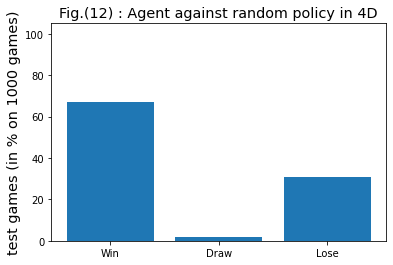

In [46]:
diag = plt.figure()
plt.bar(['Win', 'Draw', 'Lose'], np.array([wins, draw, loses]) / 10)
plt.title("Fig.(12) : Agent against random policy in 4D", fontsize='x-large')
plt.ylabel('test games (in % on 1000 games)', fontsize='x-large')
plt.ylim(0, 105)
plt.savefig("agent_vs_random_in_4D.pdf", bbox_inches='tight')

In [54]:
loaded_agent_4D = na.Model(size=3, n_dim=4)
loaded_agent_4D.load("weights_4D")
game = Game(None, None, n_dim=4, size=3)
wins, draw, loses = na.test_against_policy(agent_4D, game, advanced_policy_nD, 1000)
print("Agent against advanced policy in 4D : Win {}, Draw {}, Loses {}".format(wins, draw, loses))

100%|██████████| 1000/1000 [13:03<00:00,  1.28it/s]

Agent against advanced policy in 4D : Win 257, Draw 35, Loses 708


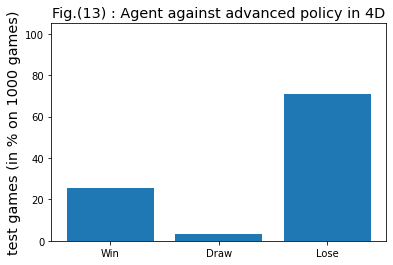

In [55]:
diag = plt.figure()
plt.bar(['Win', 'Draw', 'Lose'], np.array([wins, draw, loses]) / 10)
plt.title("Fig.(13) : Agent against advanced policy in 4D", fontsize='x-large')
plt.ylabel('test games (in % on 1000 games)', fontsize='x-large')
plt.ylim(0, 105)
plt.savefig("agent_vs_advanced_in_4D.pdf", bbox_inches='tight')

### Plots of performance evolution for Policy Gradient according to training episodes

2D case

  0%|          | 16/5000 [00:00<00:35, 139.67it/s]

1


 15%|█▌        | 15/100 [00:00<00:00, 141.24it/s]

10


  8%|▊         | 15/200 [00:00<00:01, 141.53it/s]

100


  4%|▍         | 16/400 [00:00<00:02, 149.90it/s]

200


  2%|▏         | 17/700 [00:00<00:04, 168.39it/s]

400


  2%|▏         | 16/1000 [00:00<00:06, 155.95it/s]

700


  1%|          | 18/2000 [00:00<00:12, 156.78it/s]

1000


  1%|          | 16/3000 [00:00<00:20, 143.55it/s]

2000


  0%|          | 16/4000 [00:00<00:28, 137.95it/s]

3000


  0%|          | 14/5000 [00:00<00:35, 138.85it/s]

4000


  0%|          | 15/7000 [00:00<00:46, 148.75it/s]

5000


  0%|          | 16/10000 [00:00<01:05, 151.58it/s]

7000


  0%|          | 15/15000 [00:00<01:48, 138.72it/s]

10000


  0%|          | 16/20000 [00:00<02:08, 155.08it/s]

15000


100%|██████████| 5000/5000 [00:28<00:00, 172.96it/s]


20000


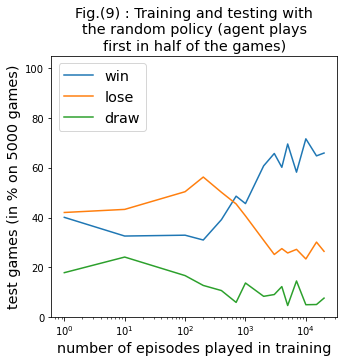

In [17]:
win1, lose1, draw1, n_eps = [], [], [], []
for n in [1, 10, 100, 200, 400, 700, 1000, 2000, 3000, 4000, 5000, 7000, 10000, 15000, 20000]:
    game = Game(None, None, n_dim=2, size=3)
    agent1 = na.Model()
    agent1, values, _, _, _ = na.train_network(agent1, game, n, 1000)
    wins, draw, loses = na.test_against_policy(agent1, game, random_policy, 5000)
    win1.append(wins)
    lose1.append(loses)
    draw1.append(draw)
    n_eps.append(n)
    print(n)
    
n_eps = np.array(n_eps)
fig = plt.figure(figsize=(0.8*6.4, 1*4.8))
plt.plot(n_eps, np.array(win1)/50, label='win')
plt.plot(n_eps, np.array(lose1)/50, label='lose')
plt.plot(n_eps, np.array(draw1)/50, label='draw')
plt.xscale('log')
plt.xlabel('number of episodes played in training', fontsize='x-large')
plt.ylabel('test games (in % on 5000 games)', fontsize='x-large')
plt.ylim(0, 105)
plt.title('Fig.(9) : Training and testing with\nthe random policy (agent plays\nfirst in half of the games)', \
          fontsize='x-large')
plt.legend(loc='upper left', fontsize='x-large')
plt.savefig("plot2d.pdf", bbox_inches='tight')

3D case

In [18]:
win1, lose1, draw1, n_eps = [], [], [], []
win1Ad, lose1Ad, draw1Ad = [], [], []
for n in [1, 10, 100, 500, 1000, 2000, 5000, 10000, 20000, 50000, 100000]:
    game = Game(None, None, n_dim=3, size=3)
    agent1 = na.Model(3, 3)
    agent1, values, _, _, _ = na.train_network(agent1, game, n, 1000, policy=advanced_policy_nD)
    wins, draw, loses = na.test_against_policy(agent1, game, random_policy, 1000)
    winsAd, drawAd, losesAd = na.test_against_policy(agent1, game, advanced_policy_nD, 1000)
    win1.append(wins)
    lose1.append(loses)
    draw1.append(draw)
    win1Ad.append(winsAd)
    lose1Ad.append(losesAd)
    draw1Ad.append(drawAd)
    n_eps.append(n)

100%|██████████| 1000/1000 [01:27<00:00, 11.45it/s]


Agent trained with the advanced policy and plays games against the random policy

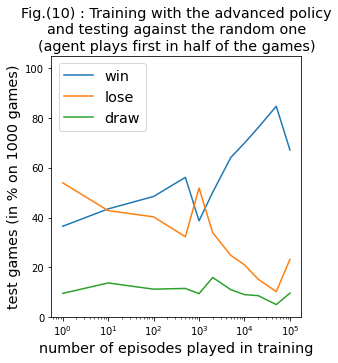

In [35]:
n_eps = np.array(n_eps)
fig = plt.figure(figsize=(0.7*6.4, 1*4.8))
plt.plot(n_eps, np.array(win1)/10, label='win')
plt.plot(n_eps, np.array(lose1)/10, label='lose')
plt.plot(n_eps, np.array(draw1)/10, label='draw')
plt.xscale('log')
plt.xlabel('number of episodes played in training', fontsize='x-large')
plt.ylabel('test games (in % on 1000 games)', fontsize='x-large')
plt.ylim(0, 105)
plt.title('Fig.(10) : Training with the advanced policy\nand testing against the random one\n(agent plays first in half of the games)', \
          fontsize='x-large')
plt.legend(loc='best', fontsize='x-large')
plt.savefig("agent_vs_random_in_3D.pdf", bbox_inches='tight')

Agent trained with the advanced policy plays games against it

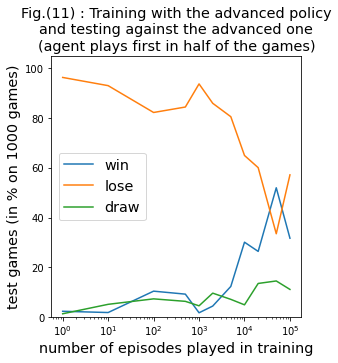

In [36]:
n_eps = np.array(n_eps)
fig = plt.figure(figsize=(0.7*6.4, 1*4.8))
plt.plot(n_eps, np.array(win1Ad)/10, label='win')
plt.plot(n_eps, np.array(lose1Ad)/10, label='lose')
plt.plot(n_eps, np.array(draw1Ad)/10, label='draw')
plt.xscale('log')
plt.xlabel('number of episodes played in training', fontsize='x-large')
plt.ylabel('test games (in % on 1000 games)', fontsize='x-large')
plt.ylim(0, 105)
plt.title('Fig.(11) : Training with the advanced policy\nand testing against the advanced one\n(agent plays first in half of the games)', \
          fontsize='x-large')
plt.legend(loc='best', fontsize='x-large')
plt.savefig("agent_vs_advanced_in_3D.pdf", bbox_inches='tight')